# BÁO CÁO BÀI TẬP THỰC HÀNH VÀ ĐỒ ÁN CUỐI KỲ



In [1]:
# import các thư viện
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
from tqdm import tqdm

In [2]:
# Các biến toàn cục

# thư mục gốc chứa thư mục dữ liệu
szWorkingDir = "/kaggle/input/car-cs114"

# dùng để hiển thị
nNumImgsPerRow = 10
nImgHeight = nImgWidth = 150

In [3]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

Đoạn mã bao gồm:

* File csv chứa ảnh lỗi: Không thể đọc được
* File csv chứa thông tin kênh màu, độ trong suốt
* File csv chứa thông tin các ảnh trùng được phát hiện thông qua bài tập Clustering (trong phần này là tập Train-1)
* Và đường dẫn dataset và train-1.csv

In [4]:
path_img = os.path.join(szWorkingDir, "dataset")
error = pd.read_csv(os.path.join(szWorkingDir,"ImageErrors.csv"))
error_paths = error.iloc[:, 0].unique().tolist() # Lấy thông tin đường dẫn ảnh lỗi

In [5]:
csv_dir = os.path.join(szWorkingDir,"car_split/car_split")
#Link train
img_path_train =os.path.join(csv_dir,"CarDataset-Splits-3-Train.csv")
# Những tập hình ảnh data có trong file Public
data_org_path =os.path.join(csv_dir,"CarDataset.csv")
#Đọc File train
data = pd.read_csv(img_path_train)

In [6]:
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1        Others/22520459-22520507-22520862.Others.23.jpg           0
2       Others/22521027-22520195-22521060.Others.307.jpg           0
3                Others/22520394-22520395.Others.578.jpg           0
4                Others/22521586-22521559.Others.169.jpg           0
...                                                  ...         ...
29385  VinFast/22520459-22520507-22520862.VinFast.34.jpg           8
29386  VinFast/22521027-22520195-22521060.VinFast.090...           8
29387          VinFast/22521070-22520211.VinFast.167.jpg           8
29388            VinFast/22521692-22521676.VinFast.7.jpg           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[29390 rows x 2 columns]

In [7]:
# Loại bỏ các ảnh có trong error_paths
data = data[~data['ImageFullPath'].isin(error_paths)]
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1        Others/22520459-22520507-22520862.Others.23.jpg           0
2       Others/22521027-22520195-22521060.Others.307.jpg           0
3                Others/22520394-22520395.Others.578.jpg           0
4                Others/22521586-22521559.Others.169.jpg           0
...                                                  ...         ...
29385  VinFast/22520459-22520507-22520862.VinFast.34.jpg           8
29386  VinFast/22521027-22520195-22521060.VinFast.090...           8
29387          VinFast/22521070-22520211.VinFast.167.jpg           8
29388            VinFast/22521692-22521676.VinFast.7.jpg           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[29368 rows x 2 columns]

In [8]:
# Đọc file chứa thông tin ảnh trùng
duplicates_df = pd.read_csv('/kaggle/input/car-cs114/CheckDuplicate/CheckDuplicate_Train_3.csv')
duplicates_df

ImageFullPath  ClusterID
0                Others/22521492-22521599.Others.49.jpg          0
1                Others/22521492-22521599.Others.50.jpg          0
2               Others/22521070-22520211.Others.167.jpg          1
3               Others/22520779-22521587.Others.948.jpg          1
4                Others/22521492-22521599.Others.83.jpg          2
...                                                 ...        ...
1447  VinFast/22521027-22520195-22521060.VinFast.074...        134
1448  VinFast/22521027-22520195-22521060.VinFast.051...        135
1449           VinFast/22520477-22520490.VinFast.55.jpg        135
1450           VinFast/22521070-22520211.VinFast.21.jpg        136
1451  VinFast/22520348-22520530-22520837.VinFast.41....        136

[1452 rows x 2 columns]

In [9]:
# Lấy các nhóm ảnh trùng
duplicate_groups = duplicates_df.groupby('ClusterID')['ImageFullPath'].agg(list)

# Xử lý từng nhóm trùng
for group in duplicate_groups:
    if len(group) > 1:
        # Chọn ngẫu nhiên 1 ảnh giữ lại
        keep_image = np.random.choice(group, 1)[0]
        # Lấy các ảnh cần loại bỏ
        remove_images = [img for img in group if img != keep_image]
        # Loại bỏ ảnh trùng trong DataFrame
        data = data[~data['ImageFullPath'].isin(remove_images)]

data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1        Others/22520459-22520507-22520862.Others.23.jpg           0
2       Others/22521027-22520195-22521060.Others.307.jpg           0
3                Others/22520394-22520395.Others.578.jpg           0
4                Others/22521586-22521559.Others.169.jpg           0
...                                                  ...         ...
29383  VinFast/22521027-22520195-22521060.VinFast.060...           8
29385  VinFast/22520459-22520507-22520862.VinFast.34.jpg           8
29386  VinFast/22521027-22520195-22521060.VinFast.090...           8
29387          VinFast/22521070-22520211.VinFast.167.jpg           8
29389          VinFast/22521070-22520211.VinFast.177.jpg           8

[28060 rows x 2 columns]

Train and val data

In [10]:
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path_img, i) for i in img]
len(image)

28060

Chia tập train và val (Train 80%, Val 20%)

In [11]:
train_X, val_X, train_Y, val_Y = train_test_split(image, label, test_size=0.2, random_state=30)
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)
print(train_label_count)
print(val_label_count)

Counter({6: 4220, 7: 3686, 0: 2687, 2: 2117, 3: 2103, 4: 2075, 1: 2020, 5: 1835, 8: 1705})
Counter({6: 1029, 7: 887, 0: 688, 1: 551, 2: 546, 3: 518, 4: 499, 5: 480, 8: 414})


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


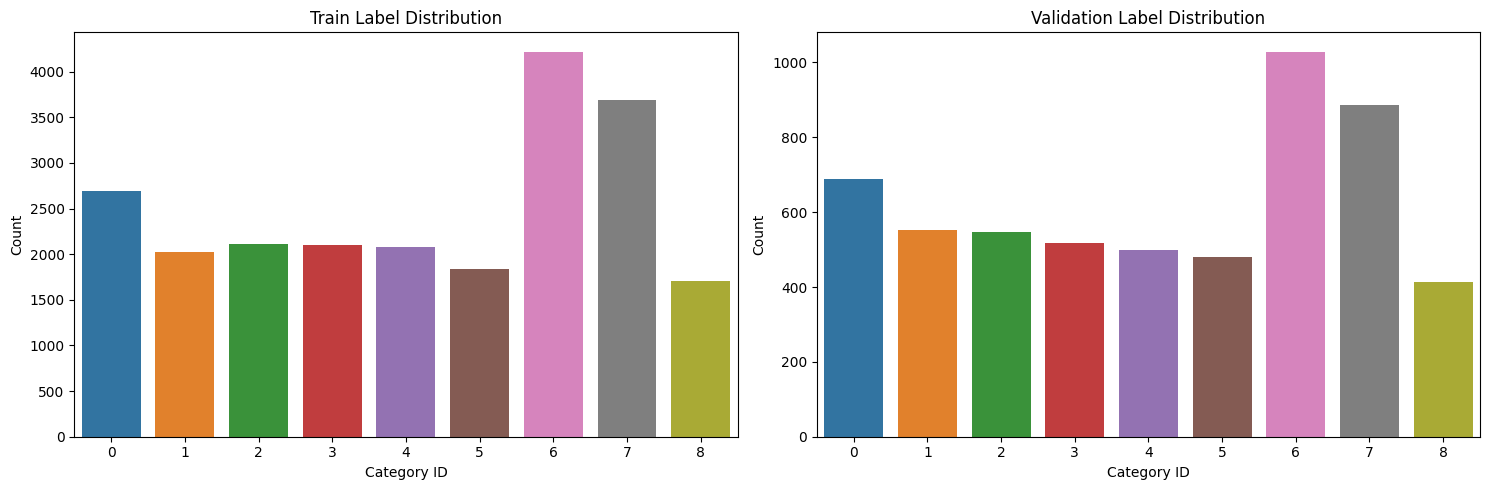

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Giả sử 'train_Y' và 'val_Y' là nhãn của dữ liệu huấn luyện và kiểm tra
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)

# Vẽ biểu đồ phân phối nhãn cho cả train và val
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution
sns.barplot(x=list(train_label_count.keys()), y=list(train_label_count.values()), ax=axes[0])
axes[0].set_title('Train Label Distribution')
axes[0].set_xlabel('Category ID')
axes[0].set_ylabel('Count')

# Validation label distribution
sns.barplot(x=list(val_label_count.keys()), y=list(val_label_count.values()), ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Category ID')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Dùng để hiển thị

* nNumImgsPerRow = 10
* nImgHeight = nImgWidth = 150

In [13]:
# Số lượng các danh mục hoặc lớp ảnh khác nhau
classes = 9

# Kích thước của mỗi ảnh trong hình
figsize_per_image = (2, 2)

def display_images(data):

    images = {}

    # Lặp qua từng lớp
    for Class in range(classes):
        # Lọc dataframe theo lớp hiện tại
        class_df = data[data['CategoryID'] == Class]

        # Lấy ngẫu nhiên các đường dẫn ảnh từ dataframe đã lọc
        sample_images = class_df.sample(n=min(nNumImgsPerRow, len(class_df)))['ImageFullPath']

        # Tải và thay đổi kích thước từng ảnh được chọn, lưu vào dictionary `images`
        images[Class] = [cv2.resize(cv2.imread(os.path.join(path_img, img_path), cv2.IMREAD_COLOR), (nImgWidth, nImgHeight)) for img_path in sample_images]

    # Tính toán kích thước hình dựa trên số lượng ảnh và số lớp
    figsize = (figsize_per_image[0] * (nNumImgsPerRow + 1), figsize_per_image[1] * classes)

    # Tạo các ô con (subplot) với số dòng là số lớp và số cột là `NumImgsPerRow + 1`
    fig, axes = plt.subplots(classes, nNumImgsPerRow + 1, figsize=figsize)

    # Hiển thị ảnh
    for i in tqdm(range(classes)):
        for j in range(nNumImgsPerRow + 1):
            # Lấy ô subplot hiện tại
            ax = axes[i, j]

            # Nếu là cột đầu tiên, hiển thị nhãn lớp
            if j == 0:
                ax.text(0.5, 0.5, f'{reverse_map_labels[i]}', va='center', ha='center', transform=ax.transAxes, fontsize=14, fontweight='bold')
            # Nếu không, hiển thị ảnh nếu tồn tại
            elif j-1 < len(images[i]):
                ax.imshow(cv2.cvtColor(images[i][j-1], cv2.COLOR_BGR2RGB))

            # Ẩn các đường viền trục để giao diện gọn gàng hơn
            ax.axis('off')

    # Điều chỉnh bố cục để tránh chồng lấn và hiển thị hình
    plt.tight_layout()
    plt.show()

100%|██████████| 9/9 [00:00<00:00, 108.00it/s]


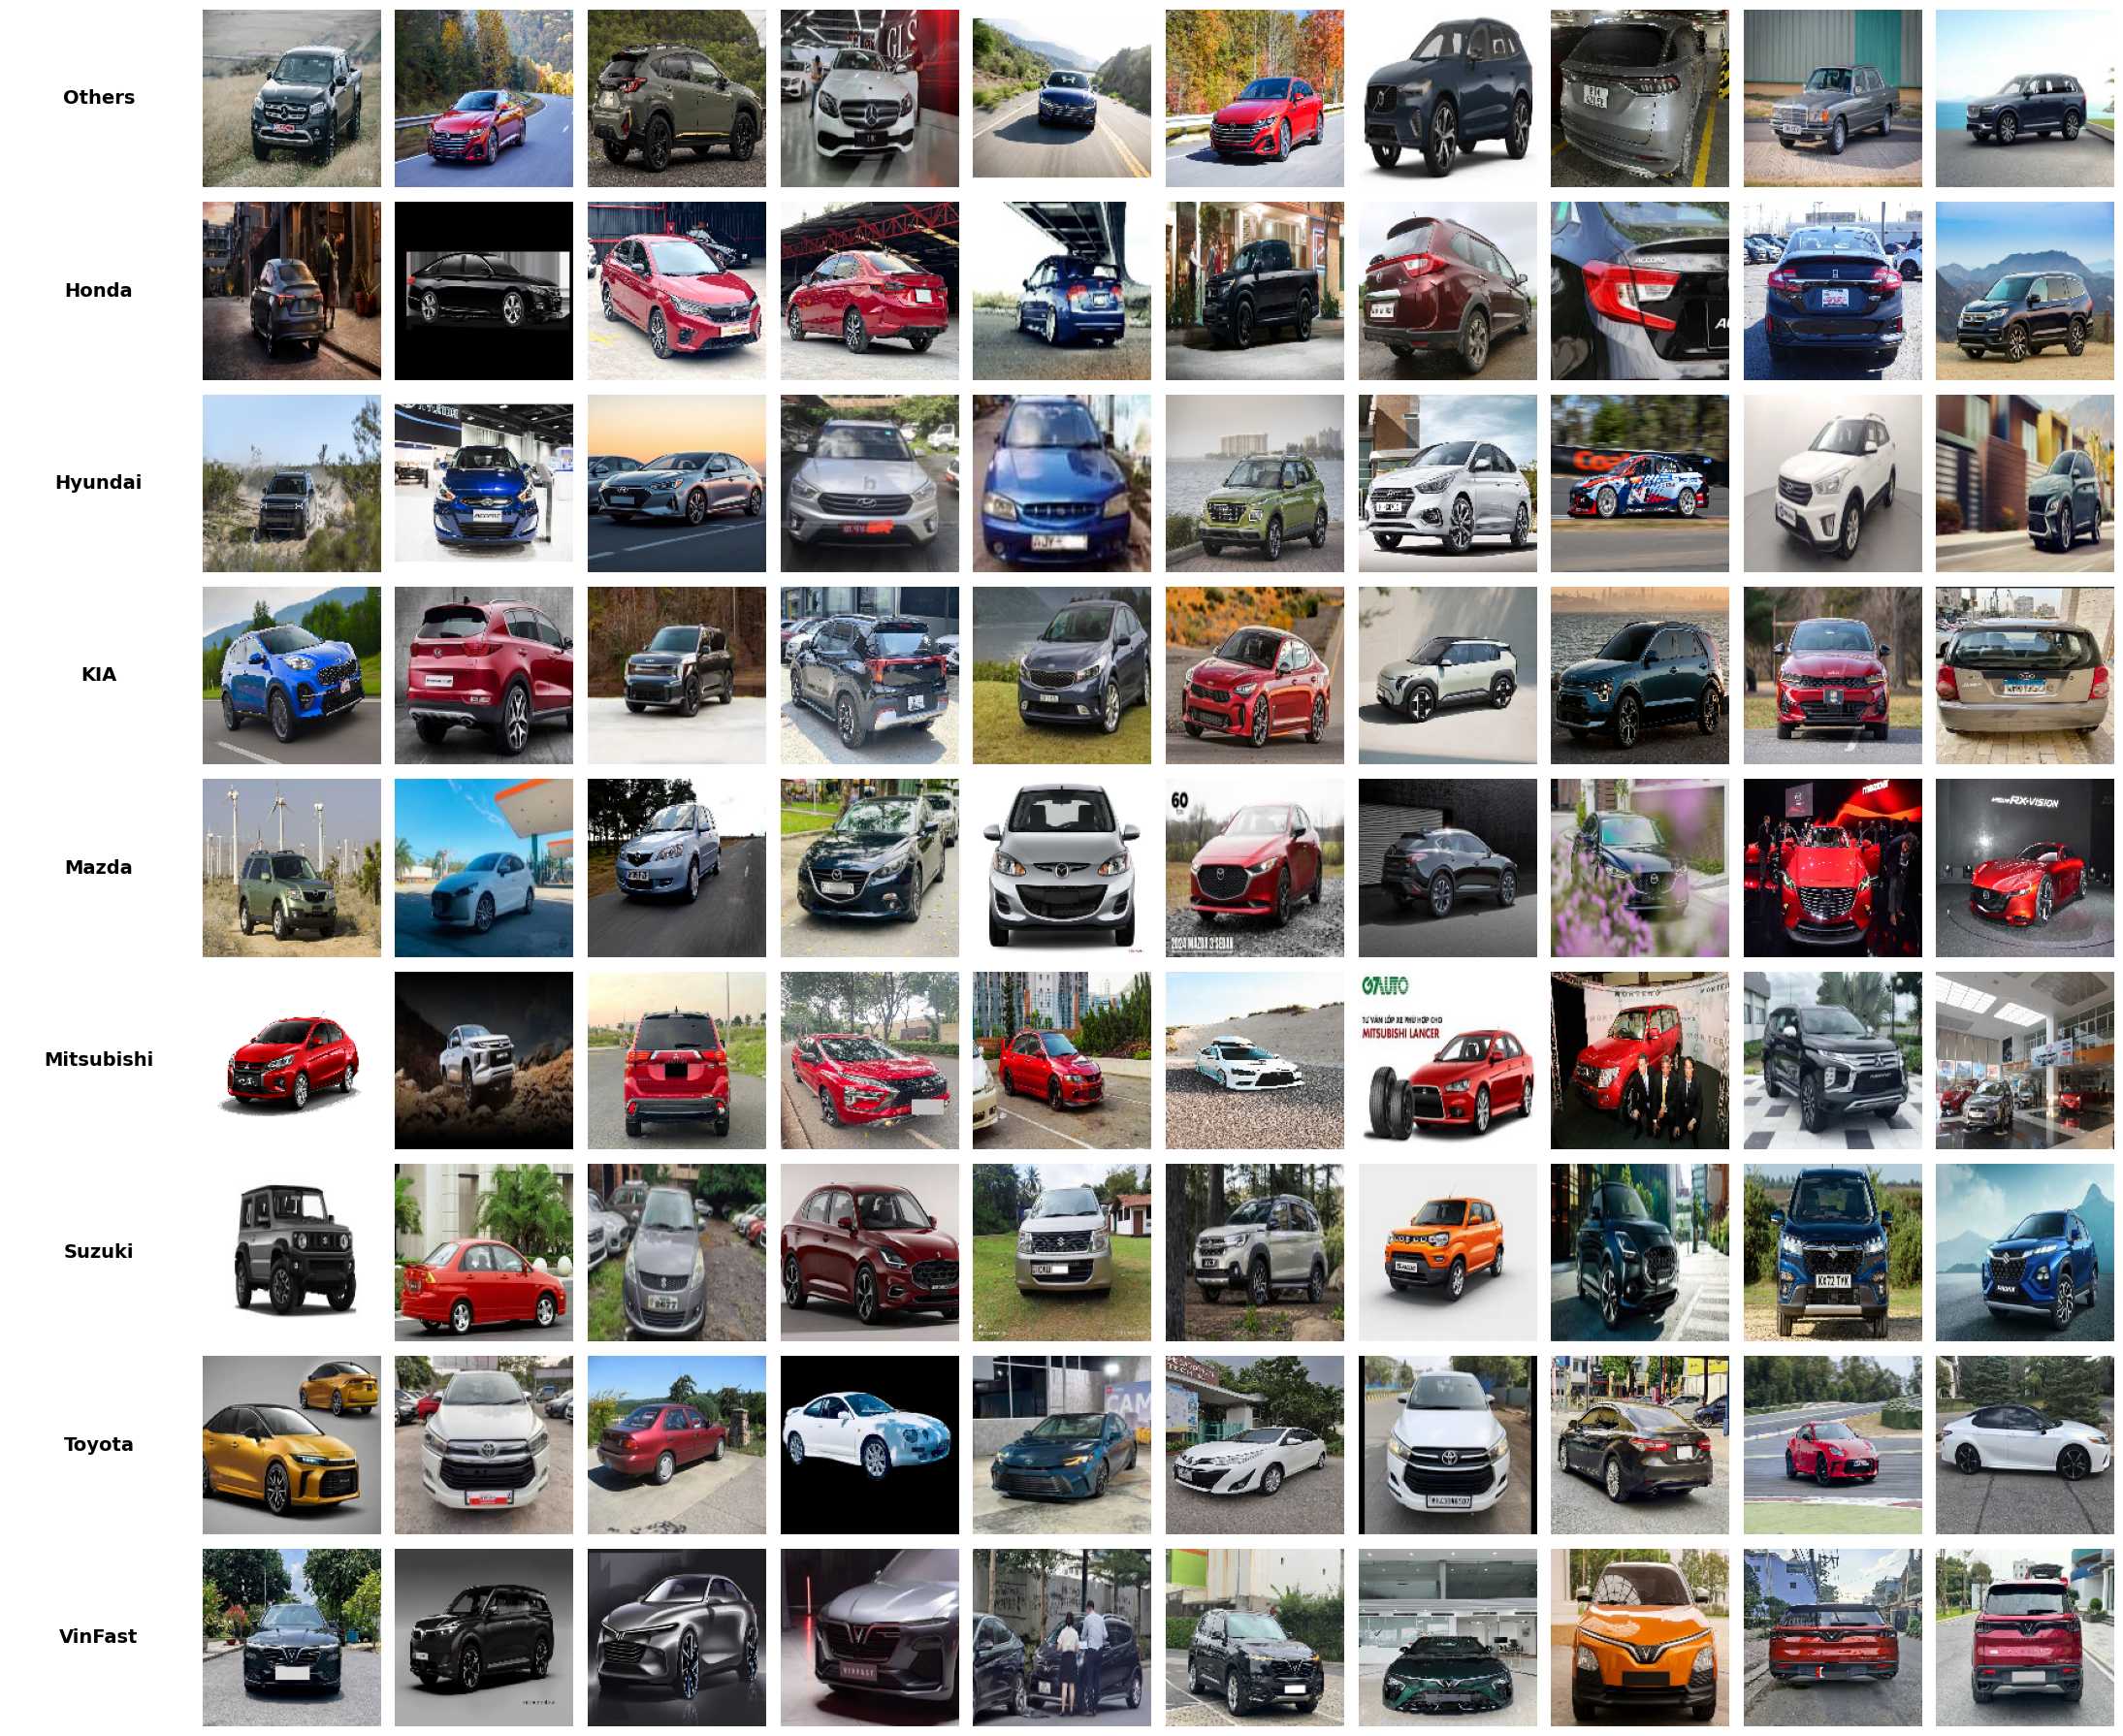

In [14]:
display_images(data)

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(224),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.RandomHorizontalFlip(),  # Lật ngang ảnh ngẫu nhiên để tăng cường dữ liệu
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(224),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
}

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Mở ảnh bằng Pillow
        img_pil = Image.open(img_path)
        # Chuyển đổi sang RGB nếu không phải
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        # Áp dụng các phép biến đổi
        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label

In [17]:
train_set = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
val_set = CustomDataset(val_X,val_Y, transform=data_transforms['val'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True,num_workers=1)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True,num_workers= 1)

In [18]:
train_set[0]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [19]:
val_set[0]

(tensor([[[-1.5185, -1.9124, -1.9295,  ..., -1.4500, -1.4843, -1.6042],
          [-1.1760, -1.0562, -1.2445,  ..., -1.7412, -1.5357, -1.3130],
          [-0.8164, -1.2959, -0.9363,  ..., -1.6727, -1.5699, -1.1760],
          ...,
          [-0.0629, -0.1143, -0.1828,  ..., -1.1418, -0.9363, -0.8335],
          [-0.0116, -0.1314, -0.2684,  ..., -1.1075, -0.8678, -0.7308],
          [-0.0287, -0.1657, -0.3198,  ..., -1.0562, -0.8678, -0.6965]],
 
         [[-1.2129, -1.6681, -1.6856,  ..., -1.1253, -1.2479, -1.4055],
          [-0.8803, -0.7752, -0.9853,  ..., -1.4230, -1.2829, -1.0728],
          [-0.5476, -1.0378, -0.6877,  ..., -1.3529, -1.2829, -0.8978],
          ...,
          [-0.1800, -0.1975, -0.2325,  ..., -1.1954, -1.0028, -0.9503],
          [-0.1625, -0.2675, -0.3725,  ..., -1.1954, -0.9678, -0.8452],
          [-0.2150, -0.3200, -0.4601,  ..., -1.1954, -0.9853, -0.8102]],
 
         [[-1.1596, -1.5779, -1.5953,  ..., -1.0550, -1.1596, -1.3513],
          [-0.8633, -0.7413,

Show 16 ảnh trong 1 batch

In [20]:
def show_batch_images(images, labels, mean, std, max_images=16):
    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Transpose tensor from (C, H, W) to (H, W, C)

        # Denormalize
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 rows and 4 columns
        plt.imshow(image)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


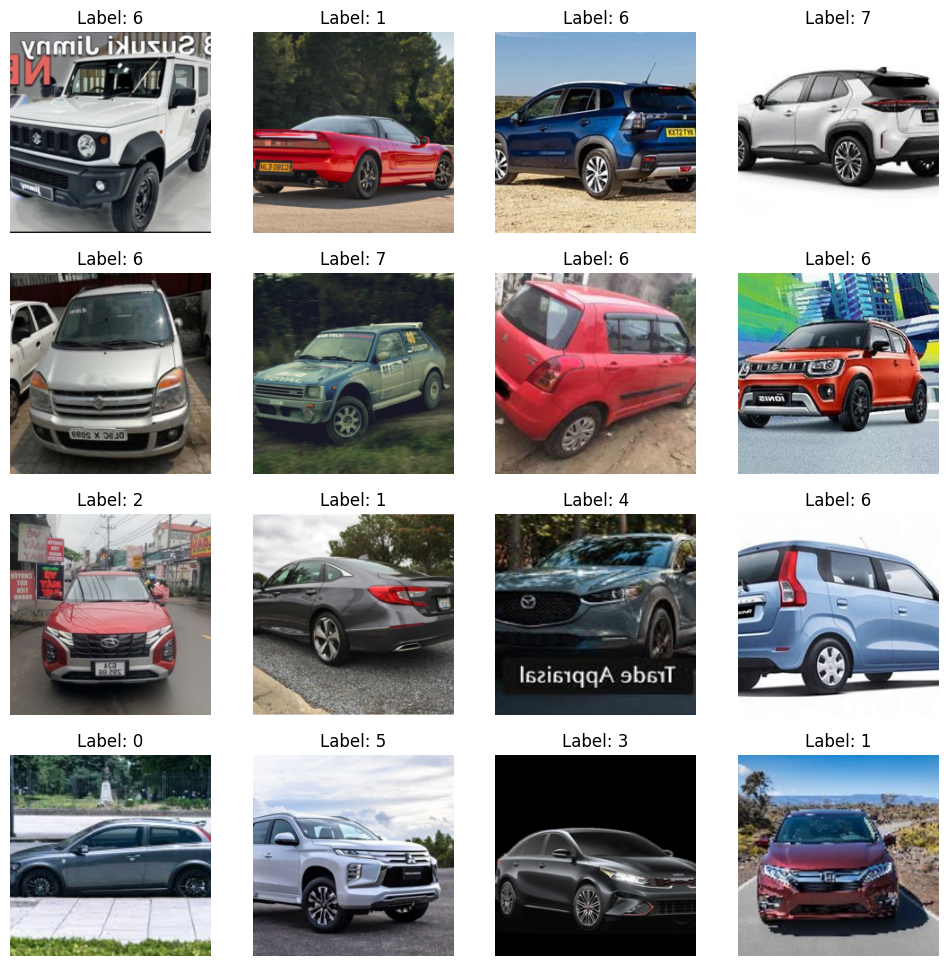

In [21]:
batch_images, batch_labels = next(iter(train_loader))  # Replace data_loader with your actual DataLoader
show_batch_images(batch_images, batch_labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [22]:
from tempfile import TemporaryDirectory
import torch.optim as optim
import time
import torchvision.models as models
from torch.optim import lr_scheduler

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
import torch
# Kiểm tra GPU memory trước khi load model
print(f"GPU memory before model: {torch.cuda.memory_allocated()/1e9:.2f} GB")
torch.cuda.empty_cache()

GPU memory before model: 0.00 GB


In [25]:
model_ft = torchvision.models.regnet_y_128gf(weights='RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_LINEAR_V1')

# Freeze all layers except the last fully connected layer
for param in model_ft.parameters():
    param.requires_grad = False


# Replace the last fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 9)
# Move model to device (GPU if available)
for param in model_ft.fc.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_lc_swag-cbe8ce12.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_lc_swag-cbe8ce12.pth
100%|██████████| 2.40G/2.40G [00:25<00:00, 100MB/s]


In [26]:
model_ft

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [27]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define learning rate scheduler (decay LR by a factor of 0.1 every 7 epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, train_loader=None, val_loader=None, device=None):
    since = time.time()
    best_acc = 0.0
    best_model_params_path = '/kaggle/working/regnet_03.pt'
    
    # Histories
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # Grad scaler for mixed precision
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                try:
                    # Move input and labels to device
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Verify shapes and values
                    assert inputs.shape[1:] == (3, 224, 224), f"Wrong input shape: {inputs.shape}"
                    assert labels.shape[0] == inputs.shape[0], f"Batch size mismatch: {labels.shape} vs {inputs.shape}"
                    assert torch.all(labels >= 0) and torch.all(labels < 9), f"Labels out of range: {labels.min()}-{labels.max()}"
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == 'train'):
                        with torch.amp.autocast('cuda'):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                except Exception as e:
                    print(f"Error in batch processing: {str(e)}")
                    print(f"Input shape: {inputs.shape}")
                    print(f"Labels shape: {labels.shape}")
                    print(f"Unique labels: {torch.unique(labels)}")
                    raise e
            
            # Epoch statistics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                
            # Update histories
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [29]:
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, train_loader=train_loader, val_loader=val_loader, device=device
)

Epoch 1/30
------------------------------


train 1/30:   0%|          | 1/702 [00:03<40:26,  3.46s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/30: 100%|██████████| 702/702 [11:25<00:00,  1.02it/s]


train Loss: 1.3837 Acc: 0.5635


val 1/30:   3%|▎         | 5/176 [00:05<02:58,  1.05s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/30: 100%|██████████| 176/176 [02:51<00:00,  1.03it/s]


val Loss: 1.3378 Acc: 0.6287

Epoch 2/30
------------------------------


train 2/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.9930 Acc: 0.6867


val 2/30:   3%|▎         | 5/176 [00:05<02:53,  1.01s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.3923 Acc: 0.6475

Epoch 3/30
------------------------------


train 3/30:   3%|▎         | 18/702 [00:17<11:00,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/30: 100%|██████████| 702/702 [11:11<00:00,  1.05it/s]


train Loss: 0.8987 Acc: 0.7234


val 3/30:   2%|▏         | 4/176 [00:04<03:00,  1.05s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.3876 Acc: 0.6577

Epoch 4/30
------------------------------


train 4/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.8204 Acc: 0.7507


val 4/30:   1%|          | 2/176 [00:02<03:42,  1.28s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.3419 Acc: 0.6693

Epoch 5/30
------------------------------


train 5/30:   0%|          | 1/702 [00:01<17:54,  1.53s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.7711 Acc: 0.7613


val 5/30:  17%|█▋        | 30/176 [00:29<02:19,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.6288 Acc: 0.6488

Epoch 6/30
------------------------------


train 6/30:   0%|          | 3/702 [00:03<12:31,  1.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/30: 100%|██████████| 702/702 [11:10<00:00,  1.05it/s]


train Loss: 0.4894 Acc: 0.8350


val 6/30:   8%|▊         | 14/176 [00:13<02:33,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/30: 100%|██████████| 176/176 [02:46<00:00,  1.06it/s]


val Loss: 1.2410 Acc: 0.6889

Epoch 7/30
------------------------------


train 7/30:   1%|          | 7/702 [00:07<10:57,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/30: 100%|██████████| 702/702 [11:11<00:00,  1.04it/s]


train Loss: 0.4333 Acc: 0.8530


val 7/30:   1%|          | 1/176 [00:01<04:52,  1.67s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/30: 100%|██████████| 176/176 [02:46<00:00,  1.05it/s]


val Loss: 1.2186 Acc: 0.6891

Epoch 8/30
------------------------------


train 8/30:   1%|▏         | 10/702 [00:09<10:55,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.4208 Acc: 0.8551


val 8/30:  14%|█▍        | 25/176 [00:24<02:24,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.2141 Acc: 0.6912

Epoch 9/30
------------------------------


train 9/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/30: 100%|██████████| 702/702 [11:11<00:00,  1.05it/s]


train Loss: 0.3919 Acc: 0.8677


val 9/30:   2%|▏         | 3/176 [00:03<03:08,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1935 Acc: 0.6964

Epoch 10/30
------------------------------


train 10/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/30: 100%|██████████| 702/702 [11:11<00:00,  1.05it/s]


train Loss: 0.3902 Acc: 0.8683


val 10/30:   2%|▏         | 3/176 [00:03<03:02,  1.05s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1708 Acc: 0.7006

Epoch 11/30
------------------------------


train 11/30:   4%|▍         | 30/702 [00:30<11:28,  1.02s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3643 Acc: 0.8767


val 11/30:   2%|▏         | 4/176 [00:04<02:55,  1.02s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1806 Acc: 0.6908

Epoch 12/30
------------------------------


train 12/30:   2%|▏         | 16/702 [00:16<10:55,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3578 Acc: 0.8811


val 12/30:  22%|██▏       | 39/176 [00:37<02:09,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1469 Acc: 0.7008

Epoch 13/30
------------------------------


train 13/30:   4%|▎         | 26/702 [00:25<11:20,  1.01s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3645 Acc: 0.8742


val 13/30:   2%|▏         | 4/176 [00:04<03:04,  1.07s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/30: 100%|██████████| 176/176 [02:48<00:00,  1.05it/s]


val Loss: 1.1722 Acc: 0.6964

Epoch 14/30
------------------------------


train 14/30:   0%|          | 2/702 [00:02<13:31,  1.16s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/30: 100%|██████████| 702/702 [11:10<00:00,  1.05it/s]


train Loss: 0.3608 Acc: 0.8774


val 14/30:   5%|▍         | 8/176 [00:08<02:42,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1487 Acc: 0.7012

Epoch 15/30
------------------------------


train 15/30:   2%|▏         | 11/702 [00:11<10:53,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3597 Acc: 0.8783


val 15/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1572 Acc: 0.7008

Epoch 16/30
------------------------------


train 16/30:   0%|          | 3/702 [00:03<12:00,  1.03s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 16/30: 100%|██████████| 702/702 [11:11<00:00,  1.05it/s]


train Loss: 0.3594 Acc: 0.8770


val 16/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 16/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1418 Acc: 0.7030

Epoch 17/30
------------------------------


train 17/30:   7%|▋         | 52/702 [00:51<10:23,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 17/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3487 Acc: 0.8814


val 17/30:   4%|▍         | 7/176 [00:07<02:44,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 17/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1746 Acc: 0.6926

Epoch 18/30
------------------------------


train 18/30:   4%|▎         | 26/702 [00:25<10:46,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 18/30: 100%|██████████| 702/702 [11:11<00:00,  1.05it/s]


train Loss: 0.3550 Acc: 0.8786


val 18/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 18/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1646 Acc: 0.6989

Epoch 19/30
------------------------------


train 19/30:   2%|▏         | 16/702 [00:17<11:00,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 19/30: 100%|██████████| 702/702 [11:13<00:00,  1.04it/s]


train Loss: 0.3529 Acc: 0.8783


val 19/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 19/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1755 Acc: 0.6949

Epoch 20/30
------------------------------


train 20/30:   1%|          | 5/702 [00:06<12:44,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 20/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3530 Acc: 0.8805


val 20/30:  14%|█▍        | 25/176 [00:24<02:22,  1.06it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 20/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1526 Acc: 0.7046

Epoch 21/30
------------------------------


train 21/30:   0%|          | 1/702 [00:01<18:09,  1.55s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 21/30: 100%|██████████| 702/702 [11:13<00:00,  1.04it/s]


train Loss: 0.3518 Acc: 0.8801


val 21/30:   9%|▉         | 16/176 [00:15<02:32,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 21/30: 100%|██████████| 176/176 [02:48<00:00,  1.05it/s]


val Loss: 1.1582 Acc: 0.6965

Epoch 22/30
------------------------------


train 22/30:   3%|▎         | 22/702 [00:22<10:56,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 22/30: 100%|██████████| 702/702 [11:11<00:00,  1.04it/s]


train Loss: 0.3476 Acc: 0.8823


val 22/30:   5%|▍         | 8/176 [00:08<02:42,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 22/30: 100%|██████████| 176/176 [02:48<00:00,  1.05it/s]


val Loss: 1.1754 Acc: 0.6976

Epoch 23/30
------------------------------


train 23/30:   1%|▏         | 9/702 [00:10<11:56,  1.03s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 23/30: 100%|██████████| 702/702 [11:14<00:00,  1.04it/s]


train Loss: 0.3577 Acc: 0.8775


val 23/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 23/30: 100%|██████████| 176/176 [02:46<00:00,  1.06it/s]


val Loss: 1.1383 Acc: 0.7033

Epoch 24/30
------------------------------


train 24/30:   1%|          | 5/702 [00:05<11:56,  1.03s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 24/30: 100%|██████████| 702/702 [11:11<00:00,  1.05it/s]


train Loss: 0.3419 Acc: 0.8846


val 24/30:   2%|▏         | 3/176 [00:04<03:30,  1.22s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 24/30: 100%|██████████| 176/176 [02:48<00:00,  1.04it/s]


val Loss: 1.1782 Acc: 0.6944

Epoch 25/30
------------------------------


train 25/30:   4%|▍         | 31/702 [00:30<10:38,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 25/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3451 Acc: 0.8835


val 25/30:  11%|█         | 19/176 [00:18<02:28,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 25/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1509 Acc: 0.6987

Epoch 26/30
------------------------------


train 26/30:  10%|▉         | 67/702 [01:05<10:08,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 26/30: 100%|██████████| 702/702 [11:14<00:00,  1.04it/s]


train Loss: 0.3566 Acc: 0.8798


val 26/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 26/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1820 Acc: 0.6960

Epoch 27/30
------------------------------


train 27/30:   1%|          | 8/702 [00:08<11:14,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 27/30: 100%|██████████| 702/702 [11:11<00:00,  1.04it/s]


train Loss: 0.3554 Acc: 0.8783


val 27/30:   3%|▎         | 6/176 [00:06<02:46,  1.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 27/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1575 Acc: 0.7001

Epoch 28/30
------------------------------


train 28/30:   2%|▏         | 11/702 [00:11<11:01,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 28/30: 100%|██████████| 702/702 [11:13<00:00,  1.04it/s]


train Loss: 0.3539 Acc: 0.8814


val 28/30:  12%|█▎        | 22/176 [00:21<02:26,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 28/30: 100%|██████████| 176/176 [02:48<00:00,  1.05it/s]


val Loss: 1.1762 Acc: 0.6998

Epoch 29/30
------------------------------


train 29/30:   1%|          | 4/702 [00:04<12:52,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 29/30: 100%|██████████| 702/702 [11:13<00:00,  1.04it/s]


train Loss: 0.3551 Acc: 0.8796


val 29/30:  10%|▉         | 17/176 [00:16<02:31,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 29/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]


val Loss: 1.1589 Acc: 0.7014

Epoch 30/30
------------------------------


train 30/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 30/30: 100%|██████████| 702/702 [11:12<00:00,  1.04it/s]


train Loss: 0.3516 Acc: 0.8819


val 30/30:   8%|▊         | 14/176 [00:13<02:33,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 30/30: 100%|██████████| 176/176 [02:47<00:00,  1.05it/s]
<ipython-input-28-f4a7458a3ab3>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

val Loss: 1.1646 Acc: 0.6971

Training complete in 421m 32s
Best val Acc: 0.7046


In [30]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

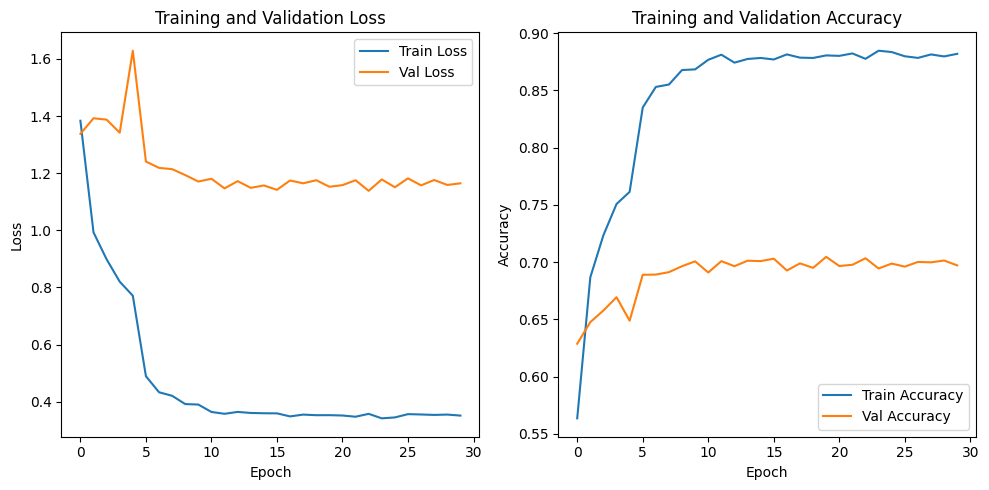

In [31]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)